## Lesson 7: Super Resolution

In [1]:
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
path = untar_data(URLs.PETS)
path_hr = path / 'images'
path_lr = path / 'small-96'
path_mr = path / 'small-256'

In [3]:
il = ImageItemList.from_folder(path_hr)

In [4]:
def resize_one(fn, i):
    dest = path_lr / fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 96, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [5]:
# to create smaller images, uncomment the next line when you run this the first time
# parallel(resize_one, il.items)

In [4]:
bs, size = 32, 128
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.1, seed=9)

In [6]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr / x.name)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [17]:
data = get_data(bs, size)

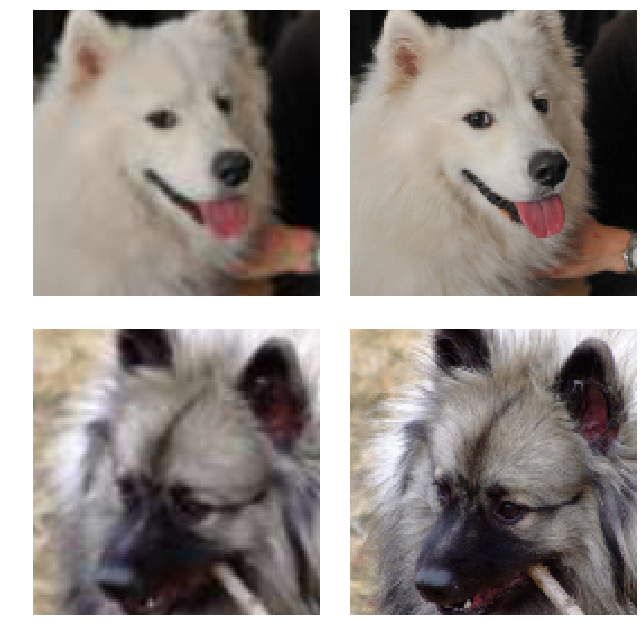

In [18]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

## Feature loss

In [23]:
t = data.valid_ds[0][1].data # get torch.Tensor from fastai.vision.image.Image

In [24]:
# Sanity check
t.shape

torch.Size([3, 128, 128])

In [25]:
t = torch.stack([t, t]) # Concatenates sequence of tensors along a new dimension

In [26]:
# Sanity check
t.shape

torch.Size([2, 3, 128, 128])

In [27]:
def gram_matrix(x):
    n, c, h, w = x.size() # n = 2, c = 3, h = 128, w = 128
    x = x.view(n, c, -1) # reshape tensor
    return (x @ x.transpose(1, 2)) / (c * h * w) # [2, 3, 16384] @ [2, 16384, 3]

In [37]:
# Sanity check
t_new = t.view(2, 3, -1)
t_new, t_new.shape

(tensor([[[0.0611, 0.0543, 0.0630,  ..., 0.1063, 0.1047, 0.1100],
          [0.0611, 0.0543, 0.0630,  ..., 0.1063, 0.1047, 0.1100],
          [0.0611, 0.0543, 0.0630,  ..., 0.1063, 0.1047, 0.1100]],
 
         [[0.0611, 0.0543, 0.0630,  ..., 0.1063, 0.1047, 0.1100],
          [0.0611, 0.0543, 0.0630,  ..., 0.1063, 0.1047, 0.1100],
          [0.0611, 0.0543, 0.0630,  ..., 0.1063, 0.1047, 0.1100]]]),
 torch.Size([2, 3, 16384]))

In [41]:
t_new.transpose(1, 2).shape

torch.Size([2, 16384, 3])

In [28]:
gram_matrix(t)

tensor([[[0.1121, 0.1037, 0.0960],
         [0.1037, 0.0968, 0.0897],
         [0.0960, 0.0897, 0.0833]],

        [[0.1121, 0.1037, 0.0960],
         [0.1037, 0.0968, 0.0897],
         [0.0960, 0.0897, 0.0833]]])

In [42]:
base_loss = F.l1_loss

In [43]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

Get layers from VGG16 network. Get a layer before MaxPool2d layer which is ReLU.

In [44]:
blocks = [i - 1 for i, o in enumerate(children(vgg_m)) if isinstance(o, nn.MaxPool2d)]

In [51]:
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [53]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
                ] + [f'gram_{i}' for i in range(len(layer_ids))]
        
    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input, target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [55]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

## Train

In [56]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect()

8002

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


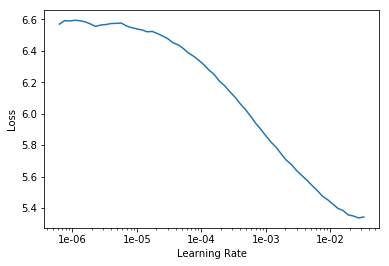

In [57]:
learn.lr_find()
learn.recorder.plot()

In [58]:
lr = 1e-3

In [59]:
# utility function
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(10, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.878758,3.765364,0.143471,0.231686,0.318524,0.225756,0.569088,1.224830,1.052009
2,3.746968,3.623530,0.146915,0.228077,0.310260,0.217326,0.531060,1.177929,1.011963
3,3.683856,3.542798,0.144409,0.225192,0.304307,0.212406,0.523345,1.143946,0.989192
4,3.625614,3.495890,0.148949,0.225164,0.301398,0.209922,0.506778,1.128076,0.975601
5,3.575768,3.412124,0.142050,0.220418,0.293528,0.205400,0.488623,1.102801,0.959304
6,3.530985,3.363271,0.144510,0.222042,0.292827,0.200777,0.482796,1.082339,0.937979
7,3.483688,3.300640,0.140738,0.220030,0.288998,0.198624,0.460092,1.063068,0.929091
8,3.479184,3.300606,0.138870,0.219142,0.287727,0.197092,0.472708,1.066907,0.918159
9,3.437450,3.271332,0.144248,0.220011,0.287269,0.196026,0.453093,1.057170,0.913514
10,3.353931,3.148826,0.136380,0.215376,0.278493,0.188945,0.429711,1.018132,0.881789


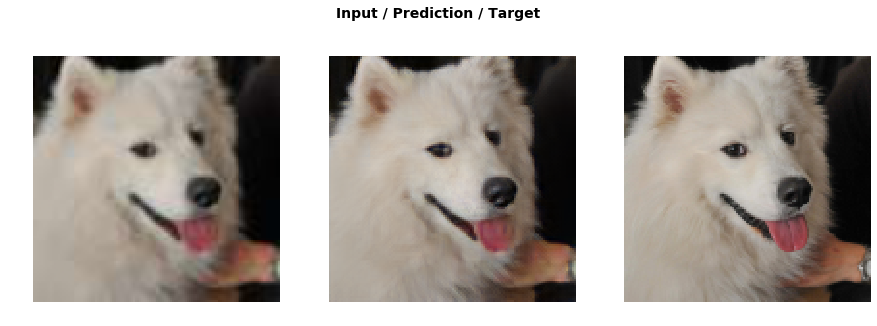

In [60]:
do_fit('superres_1a', slice(lr*10))

In [61]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,3.323620,3.144714,0.135964,0.215112,0.278066,0.188430,0.430221,1.017568,0.879353
2,3.299178,3.139331,0.136003,0.215047,0.277739,0.188079,0.428874,1.016128,0.877462
3,3.304949,3.134083,0.135695,0.214730,0.277511,0.187799,0.427655,1.013973,0.876721
4,3.288480,3.132256,0.135890,0.215035,0.277453,0.187660,0.427123,1.013997,0.875097
5,3.303428,3.128728,0.136634,0.214946,0.277462,0.187666,0.424878,1.012343,0.874799
6,3.289925,3.122605,0.136543,0.214064,0.276433,0.187116,0.425160,1.010485,0.872804
7,3.292779,3.113085,0.135635,0.213773,0.276006,0.186685,0.423021,1.007254,0.870709
8,3.276536,3.104526,0.135603,0.213475,0.275559,0.185891,0.421933,1.005491,0.866574
9,3.262141,3.108630,0.136470,0.213704,0.275759,0.186213,0.420140,1.007921,0.868424
10,3.274122,3.088803,0.135310,0.213197,0.274378,0.185061,0.417686,1.000610,0.862560


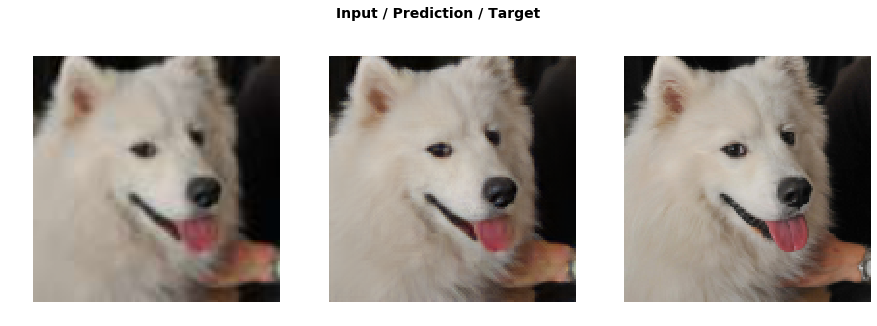

In [62]:
do_fit('superres_1b', slice(1e-5, lr))

In [7]:
data = get_data(12, size*2)

In [64]:
learn.data = data
learn.freeze()
gc.collect()

18621

In [65]:
learn.load('superres_1b')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (6651 items)
[Image (3, 331, 500), Image (3, 500, 335), Image (3, 375, 500), Image (3, 500, 333), Image (3, 375, 500)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96
x: ImageImageList (6651 items)
[Image (3, 96, 145), Image (3, 143, 96), Image (3, 96, 128), Image (3, 144, 96), Image (3, 96, 128)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList
y: ImageItemList (739 items)
[Image (3, 500, 333), Image (3, 500, 344), Image (3, 375, 500), Image (3, 500, 333), Image (3, 500, 375)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96
x: ImageImageList (739 items)
[Image (3, 144, 96), Image (3, 139, 96), Image (3, 96, 128), Image (3, 144, 96), Image (3, 128, 96)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=F

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.223401,2.208069,0.163590,0.258079,0.294132,0.155751,0.390485,0.582918,0.363114
2,2.207594,2.177671,0.164055,0.259362,0.293865,0.154717,0.373807,0.573298,0.358567
3,2.191846,2.158177,0.166473,0.260517,0.293283,0.154534,0.360691,0.566488,0.356189
4,2.164305,2.146150,0.166441,0.258691,0.290845,0.152078,0.360703,0.564724,0.352669
5,2.135329,2.135777,0.167998,0.259458,0.289835,0.152016,0.354082,0.561161,0.351228
6,2.139521,2.116349,0.167046,0.257672,0.287944,0.150504,0.347994,0.555875,0.349314
7,2.102883,2.111770,0.167683,0.257555,0.286768,0.150004,0.348646,0.553397,0.347716
8,2.111377,2.101841,0.165881,0.257276,0.286179,0.149490,0.345602,0.552041,0.345372
9,2.087749,2.092504,0.165618,0.257330,0.285525,0.149661,0.339318,0.548332,0.346720
10,2.070814,2.073214,0.166590,0.257045,0.283973,0.147354,0.333878,0.542669,0.341706


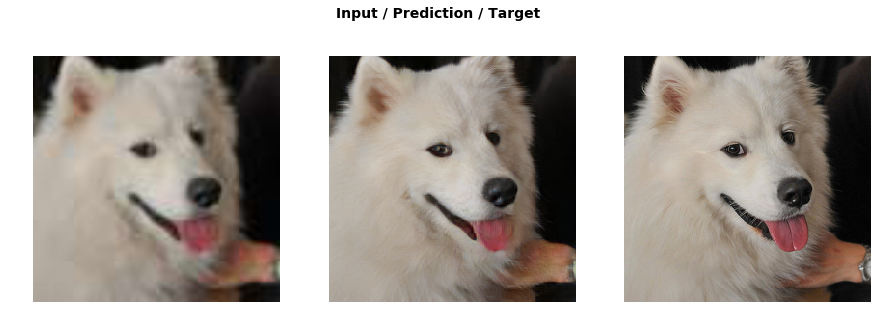

In [66]:
do_fit('superres_2a')

In [67]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,2.083004,2.072233,0.166136,0.256832,0.283742,0.147315,0.334218,0.542541,0.341448
2,2.055553,2.069016,0.165861,0.256336,0.283636,0.147269,0.333190,0.541869,0.340853
3,2.065424,2.067941,0.166512,0.256510,0.283271,0.146918,0.333683,0.541213,0.339833
4,2.063064,2.063793,0.165930,0.256200,0.283104,0.146570,0.332284,0.540426,0.339278
5,2.068301,2.062547,0.166182,0.256659,0.283385,0.146777,0.330254,0.539938,0.339351
6,2.058124,2.058460,0.165859,0.255868,0.282628,0.146286,0.331050,0.538475,0.338294
7,2.055563,2.058390,0.166337,0.256425,0.282894,0.146360,0.329987,0.538086,0.338300
8,2.059268,2.055973,0.166258,0.256073,0.282665,0.146101,0.329223,0.537654,0.337999
9,2.046954,2.055591,0.166408,0.256502,0.283080,0.146351,0.327730,0.537261,0.338258
10,2.049621,2.055515,0.166337,0.256031,0.282606,0.146133,0.329076,0.537291,0.338040


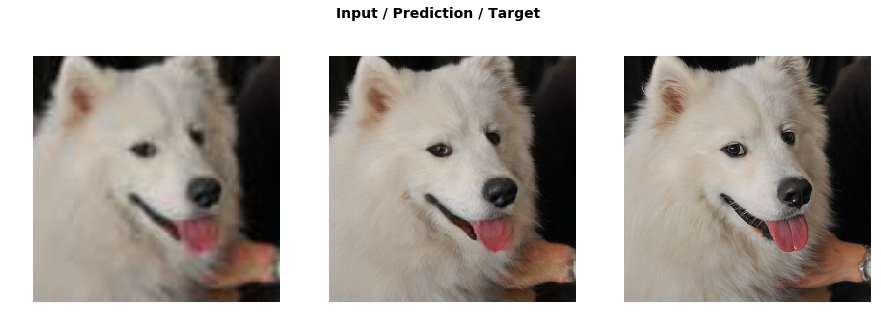

In [68]:
do_fit('superres_2b', slice(1e-6, 1e-4), pct_start=0.3)

## Test

In [69]:
learn = None
gc.collect()

11276

In [70]:
256/320*1024

819.2

In [71]:
256/320*1600

1280.0

Create medium size images.

In [77]:
def mr_resize_one(fn, i):
    dest = path_mr / fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 256, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [78]:
# to create smaller images, uncomment the next line when you run this the first time
# parallel(mr_resize_one, il.items)

In [8]:
learn = unet_learner(data, arch, loss_func=F.l1_loss, blur=True, norm_type=NormType.Weight)

In [9]:
data_mr = (ImageImageList.from_folder(path_mr).random_split_by_pct(0.1, seed=42)
          .label_from_func(lambda x: path_hr / x.name)
          .transform(get_transforms(), size=(1280,1600), tfm_y=True)
          .databunch(bs=1).normalize(imagenet_stats, do_y=True))
data_mr.c = 3

In [10]:
learn.load('superres_2b')

Learner(data=ImageDataBunch;

Train: LabelList
y: ImageItemList (6651 items)
[Image (3, 331, 500), Image (3, 500, 335), Image (3, 375, 500), Image (3, 500, 333), Image (3, 375, 500)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96
x: ImageImageList (6651 items)
[Image (3, 96, 145), Image (3, 143, 96), Image (3, 96, 128), Image (3, 144, 96), Image (3, 96, 128)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96;

Valid: LabelList
y: ImageItemList (739 items)
[Image (3, 500, 333), Image (3, 500, 344), Image (3, 375, 500), Image (3, 500, 333), Image (3, 500, 375)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96
x: ImageImageList (739 items)
[Image (3, 144, 96), Image (3, 139, 96), Image (3, 96, 128), Image (3, 144, 96), Image (3, 128, 96)]...
Path: /home/ubuntu/.fastai/data/oxford-iiit-pet/small-96;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=F

In [11]:
learn.data = data_mr

In [24]:
fn = data_mr.valid_ds.x.items[2]
fn

PosixPath('/home/ubuntu/.fastai/data/oxford-iiit-pet/small-256/shiba_inu_83.jpg')

In [25]:
img = open_image(fn)
img.shape

torch.Size([3, 256, 341])

In [26]:
%%time

p, img_hr, b = learn.predict(img)

CPU times: user 1.98 s, sys: 368 ms, total: 2.35 s
Wall time: 1.74 s


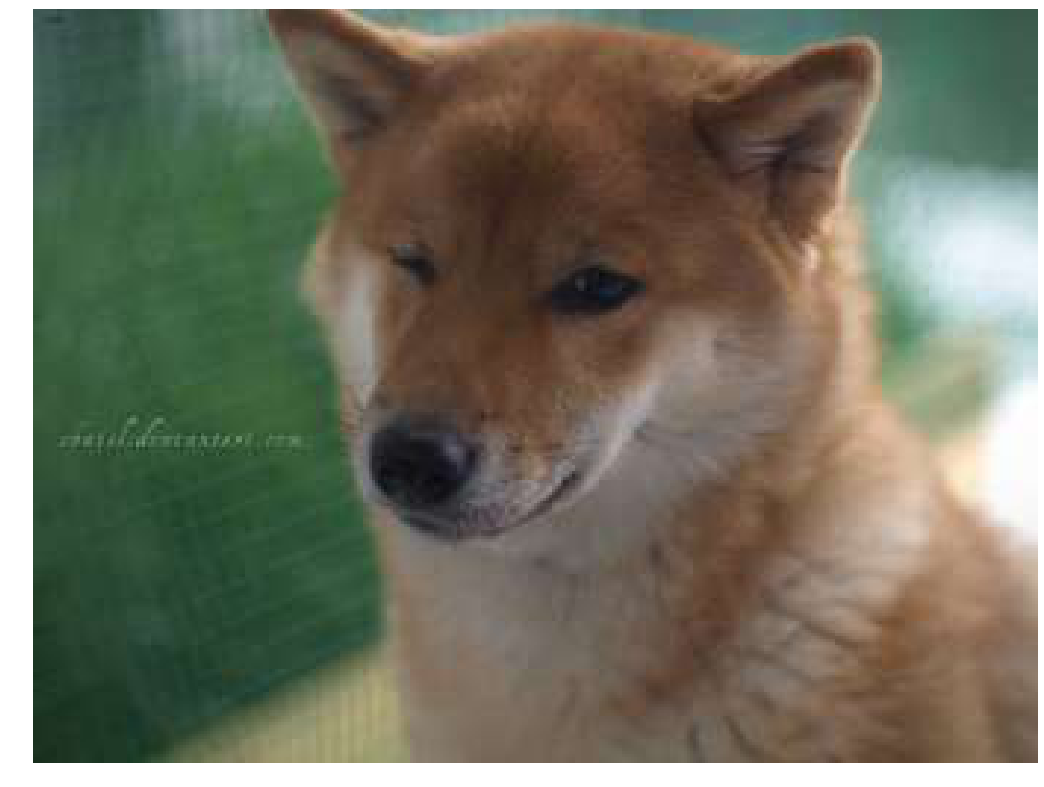

In [27]:
# Show medium res image
show_image(img, figsize=(18, 15), interpolation='nearest')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


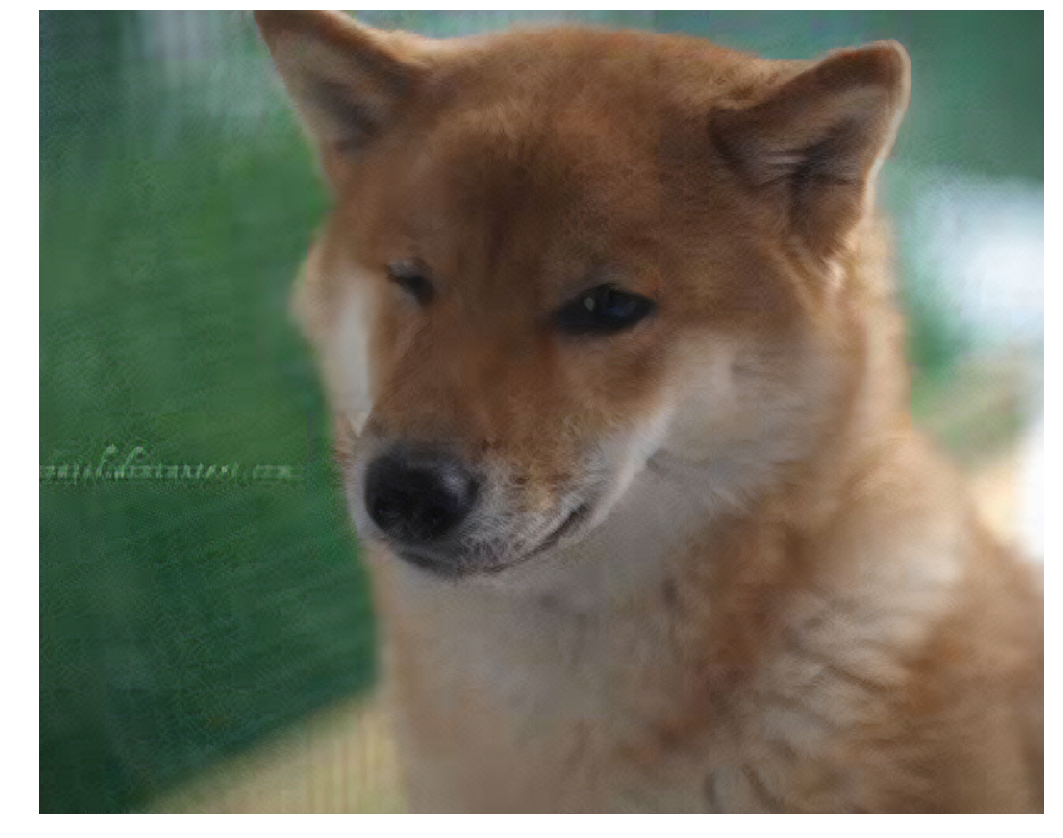

In [28]:
# Show predicted (high res) image
Image(img_hr).show(figsize=(18, 15))